In [1]:
import pandas as pd

file_url = 'https://raw.githubusercontent.com/ajayt0m/Forecasting_Crop_Prices_Maharashtra/main/onion_daily.csv'

onion_df = pd.read_csv(file_url, parse_dates=["date_arrival"])

In [36]:
onion_grouped = onion_df.groupby('date_arrival').agg({'MIN': 'mean', 'MAX': 'mean', 'MODAL': 'mean', 'Arrival': 'sum'}).reset_index()

In [39]:
#Set index as date
onion_grouped.set_index('date_arrival', inplace=True)

# Decompose

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample the data to ensure all days are included, filling missing values with NaN
onion_grouped = onion_grouped.resample('D').asfreq()

# Fill missing values using an appropriate method, such as forward fill or interpolation
onion_grouped['MODAL'].fillna(method='ffill', inplace=True)  # Forward fill missing values

# Fill missing values using an appropriate method, such as forward fill or interpolation
onion_grouped['Arrival'].fillna(method='ffill', inplace=True)  # Forward fill missing values

# Fill missing values using an appropriate method, such as forward fill or interpolation
onion_grouped['MIN'].fillna(method='ffill', inplace=True)  # Forward fill missing values
onion_grouped['MAX'].fillna(method='ffill', inplace=True)  # Forward fill missing values

In [41]:
onion_grouped.isna().sum()

MIN        0
MAX        0
MODAL      0
Arrival    0
dtype: int64

In [42]:
onion_grouped.shape

(1004, 4)

In [9]:
onion_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2021-01-01 to 2023-10-01
Freq: D
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MIN      1004 non-null   float64
 1   MAX      1004 non-null   float64
 2   MODAL    1004 non-null   float64
 3   Arrival  1004 non-null   float64
dtypes: float64(4)
memory usage: 39.2 KB


In [43]:
# Drop unwanted columns

# List of columns to drop
columns_to_drop = ['MIN', 'MAX']

# Drop the specified columns
onion_grouped.drop(columns=columns_to_drop, inplace=True)

In [44]:
onion_grouped

,MODAL,Arrival
date_arrival,,
2021-01-01,2060.604167,11575.00
2021-01-02,2181.844444,15560.00
2021-01-03,2141.176471,3954.00
2021-01-04,2167.551020,21441.00
2021-01-05,2275.469388,21526.00
...,...,...
2023-09-27,1978.393939,17023.00
2023-09-28,2104.411765,10241.00
2023-09-29,1874.296296,10973.12


# Splitting

In [45]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(onion_grouped, test_size= 0.20, shuffle=False)

# Scaling

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [47]:
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.fit_transform(test)

# Tensorflow

In [131]:
#%pip install tensorflow

In [48]:
from keras.preprocessing.sequence import TimeseriesGenerator

#lookback
n_input = 7
n_features = 2

generatorTrain = TimeseriesGenerator(train_transformed, train_transformed, length=n_input, batch_size=1)

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [50]:
#define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               41200     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 41402 (161.73 KB)
Trainable params: 41402 (161.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
#fit model
model.fit(generatorTrain, epochs=15)

Epoch 1/15
796/796 [==============================] - 4s 4ms/step - loss: 0.0257
Epoch 2/15
796/796 [==============================] - 3s 3ms/step - loss: 0.0201
Epoch 3/15
796/796 [==============================] - 4s 4ms/step - loss: 0.0183
Epoch 4/15
796/796 [==============================] - 3s 4ms/step - loss: 0.0166
Epoch 5/15
796/796 [==============================] - 3s 3ms/step - loss: 0.0156
Epoch 6/15
796/796 [==============================] - 3s 4ms/step - loss: 0.0149
Epoch 7/15
796/796 [==============================] - 3s 4ms/step - loss: 0.0143
Epoch 8/15
796/796 [==============================] - 3s 3ms/step - loss: 0.0140
Epoch 9/15
796/796 [==============================] - 3s 3ms/step - loss: 0.0135
Epoch 10/15
796/796 [==============================] - 3s 3ms/step - loss: 0.0131
Epoch 11/15
796/796 [==============================] - 3s 3ms/step - loss: 0.0129
Epoch 12/15
796/796 [==============================] - 3s 3ms/step - loss: 0.0126
Epoch 13/15
796/796 [====

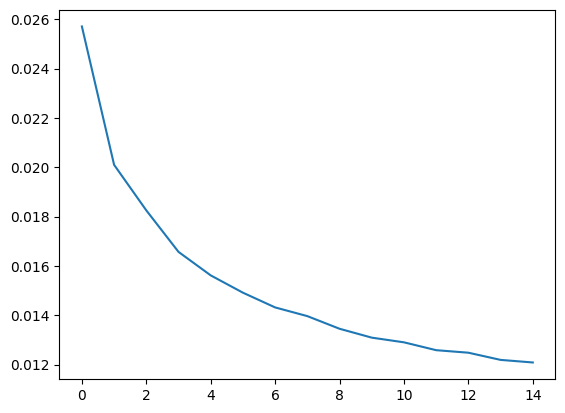

In [53]:
import matplotlib.pyplot as plt

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

# Prediction

In [67]:
last_train_batch = train_transformed[-7:]

In [68]:
last_train_batch = last_train_batch.reshape((1,n_input,n_features))

In [69]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 28ms/step


array([[0.07153178, 0.7269199 ]], dtype=float32)

In [70]:
test_transformed[0]

array([0.13100074, 0.5201888 ])

In [71]:
import numpy as np

test_predictions = []

first_eval_batch = train_transformed[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


In [72]:
test_predictions

[array([0.07153178, 0.7269199 ], dtype=float32),
 array([0.08837889, 0.62074924], dtype=float32),
 array([0.09128176, 0.48178926], dtype=float32),
 array([0.08933163, 0.36095425], dtype=float32),
 array([0.11069764, 0.1061401 ], dtype=float32),
 array([0.12273971, 0.5315868 ], dtype=float32),
 array([0.13926758, 0.44658762], dtype=float32),
 array([0.15591617, 0.40854394], dtype=float32),
 array([0.17196581, 0.38319737], dtype=float32),
 array([0.18820402, 0.36304662], dtype=float32),
 array([0.20065047, 0.29024118], dtype=float32),
 array([0.20409372, 0.12541558], dtype=float32),
 array([0.21986498, 0.49494   ], dtype=float32),
 array([0.22859934, 0.44989145], dtype=float32),
 array([0.2409612 , 0.42458326], dtype=float32),
 array([0.25517303, 0.39219227], dtype=float32),
 array([0.2703724 , 0.34656876], dtype=float32),
 array([0.28874308, 0.26719925], dtype=float32),
 array([0.29564303, 0.14783439], dtype=float32),
 array([0.31099313, 0.5091128 ], dtype=float32),
 array([0.3152508, 0

In [73]:
test.head()

,MODAL,Arrival
date_arrival,,
2023-03-15,819.517857,59885.0
2023-03-16,828.835821,56889.0
2023-03-17,827.830189,32850.0
2023-03-18,817.875000,32402.0
2023-03-19,918.515152,10571.0


In [75]:
true_predictions = scaler.inverse_transform(test_predictions)

In [274]:
import pandas as pd

# Assuming 'true_predictions' is your array
test['Pred_Min'] = true_predictions[:, 0]
test['Pred_Max'] = true_predictions[:, 1]
test['Pred_Modal'] = true_predictions[:, 2]
test['Pred_Arrival'] = true_predictions[:, 3]

In [76]:
test['Pred_Modal'] = true_predictions[:, 0]
test['Pred_Arrival'] = true_predictions[:, 1]

In [77]:
test

,MODAL,Arrival,Pred_Modal,Pred_Arrival
date_arrival,,,,
2023-03-15,819.517857,59885.00,731.587627,83185.867660
2023-03-16,828.835821,56889.00,756.497603,71219.267043
2023-03-17,827.830189,32850.00,760.789752,55556.949408
2023-03-18,817.875000,32402.00,757.906320,41937.515020
2023-03-19,918.515152,10571.00,789.497892,13217.156751
...,...,...,...,...
2023-09-27,1978.393939,17023.00,2986.944244,148942.500894
2023-09-28,2104.411765,10241.00,2998.945022,149500.815239
2023-09-29,1874.296296,10973.12,3011.031992,150062.730486


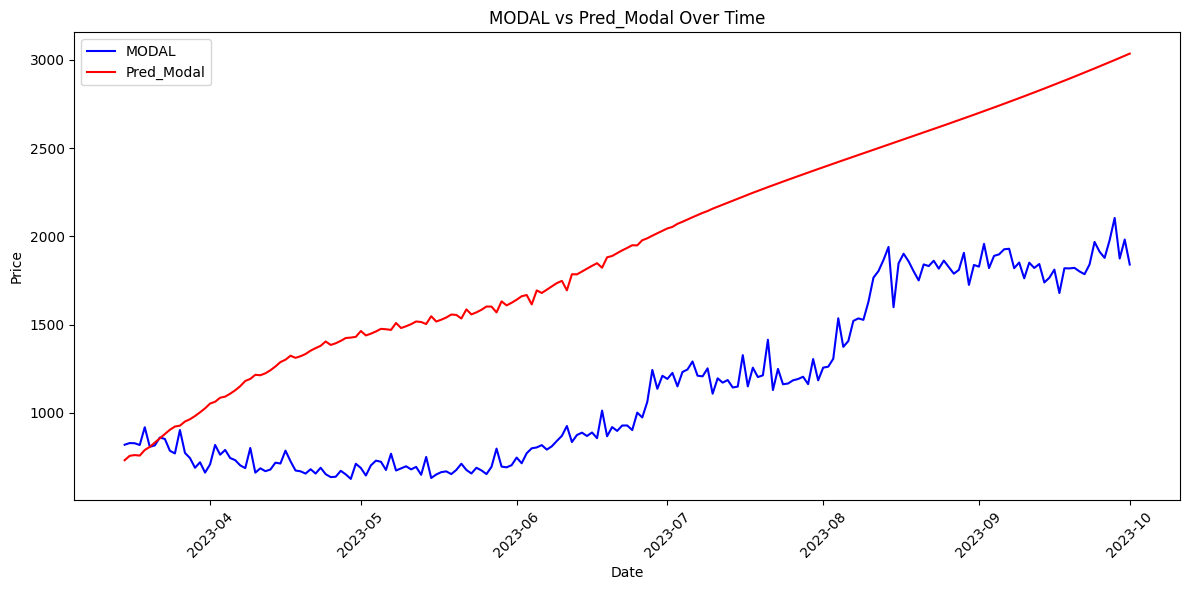

In [78]:
import matplotlib.pyplot as plt

# Assuming you have already set the date as the index
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(test.index, test['MODAL'], label='MODAL', color='blue', linestyle='-')
plt.plot(test.index, test['Pred_Modal'], label='Pred_Modal', color='red', linestyle='-')

# Customize the chart
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MODAL vs Pred_Modal Over Time')
plt.legend()  # Add a legend to differentiate the two lines

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the chart
plt.tight_layout()
plt.show()